### Case 4: For Amplitude (A) = 2.5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tcn import TCN, tcn_full_summary
from tqdm import tqdm
import time

from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,r2_score
from keras.losses import Huber
import keras.backend as K

from utilis import QuCal, pre_processing, plot_losses
from model import TCN_autoencoder

2025-02-05 15:18:31.791905: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 15:18:31.937247: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
Y = np.load('../dataset/Data_Y.npy', allow_pickle=True)
Y.shape

(3700, 512, 1)

lowest frequency for the data:  4.260000000000001
number of frewuencies: 3700


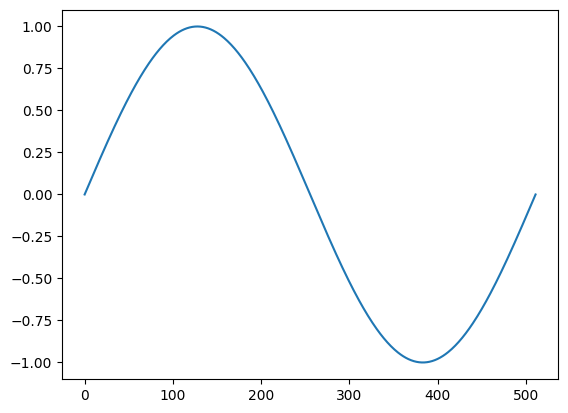

In [3]:
full_ω, t, E = QuCal()

100%|███████████████████████████████████| 3700/3700 [00:00<00:00, 161689.15it/s]

omega values for input data:  (3700,)
x data : (3700, 512)


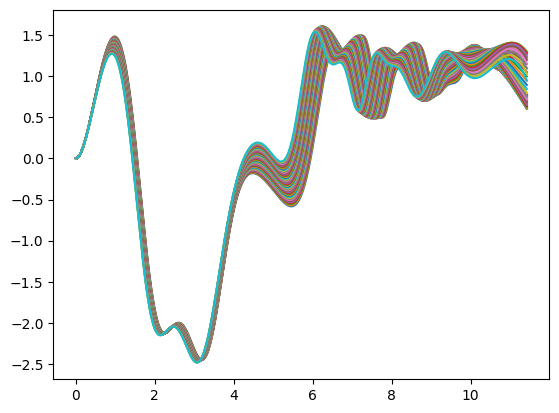

scaled_X_train:  (2960, 512, 1)
scaled_y_train:  (2960, 512, 1)
scaled_X_test:  (740, 512, 1)
scaled_y_test:  (740, 512, 1)
scaled_X_train max:  1.0
scaled_X_train min:  3.6617265e-11
scaled_y_train max:  0.99986005
scaled_y_train min :  0.0


In [ ]:
scaled_X_train, scaled_y_train,scaled_X_test,scaled_y_test, omega_y_test = pre_processing(Y , full_ω,t, F0 = 2.5 )

In [5]:

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

with mirrored_strategy.scope():
    

    TCN_AE = TCN_autoencoder(input_size=512,f1 = 8,f2 = 8, lf = 6,latent_space_tcn = True,last_2_layer_dense = False)
    #Compile the model
    TCN_AE.compile(optimizer=Adam(learning_rate = 0.001), loss=Huber(delta=1.0))



#Define a callback to save the best model
checkpoint_filepath = 'outputs/best_1d_tcn_model_v10_bkp.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#Display the model architecture
TCN_AE.summary()

2025-02-05 15:18:45.515454: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 15:18:45.989493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46614 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2025-02-05 15:18:45.990186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46614 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1e:00.0, compute capability: 8.6
2025-02-05 15:18:45.990713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 tcn (TCN)                   (None, 512, 8)            1048      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 8)           0         
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 256, 8)            1200      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 8)           0         
 1D)                                                             
                                                                 
 tcn_2 (TCN)                 (None, 128, 6)            774   

Epoch 1/50


2025-02-05 15:18:57.416837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2025-02-05 15:18:57.916860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - ETA: 0s - loss: 0.0824
Epoch 1: val_loss improved from inf to 0.03456, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 13s 161ms/step - loss: 0.0824 - val_loss: 0.0346
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0295
Epoch 2: val_loss improved from 0.03456 to 0.02558, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 2s 72ms/step - loss: 0.0294 - val_loss: 0.0256
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0232
Epoch 3: val_loss improved from 0.02558 to 0.02057, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [==============================] - 2s 85ms/step - loss: 0.0232 - val_loss: 0.0206
Epoch 4/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0179
Epoch 4: val_loss improved from 0.02057 to 0.01616, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
24/24 [======================

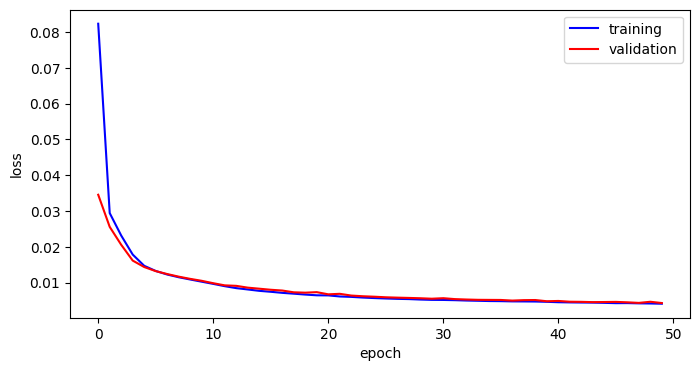

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.0041
Epoch 1: val_loss improved from 0.00429 to 0.00426, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 46ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.0041
Epoch 2: val_loss improved from 0.00426 to 0.00415, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 43ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.0039
Epoch 3: val_loss improved from 0.00415 to 0.00390, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [==============================] - 2s 43ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: 0.0038
Epoch 4: val_loss improved from 0.00390 to 0.00382, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
47/47 [=========

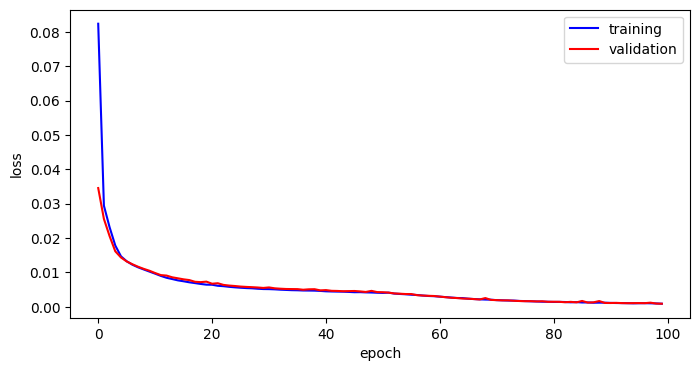

Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 0.0011
Epoch 1: val_loss did not improve from 0.00091
93/93 [==============================] - 4s 42ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 9.2880e-04
Epoch 2: val_loss did not improve from 0.00091
93/93 [==============================] - 4s 45ms/step - loss: 9.2880e-04 - val_loss: 9.6608e-04
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 9.1704e-04
Epoch 3: val_loss improved from 0.00091 to 0.00087, saving model to outputs/best_1d_tcn_model_v10_bkp.h5
93/93 [==============================] - 4s 47ms/step - loss: 9.1704e-04 - val_loss: 8.7333e-04
Epoch 4/50
93/93 [==============================] - ETA: 0s - loss: 8.6157e-04
Epoch 4: val_loss did not improve from 0.00087
93/93 [==============================] - 4s 44ms/step - loss: 8.6157e-04 - val_loss: 9.9812e-04
Epoch 5/50
93/93 [==============================] - ETA: 0s - loss

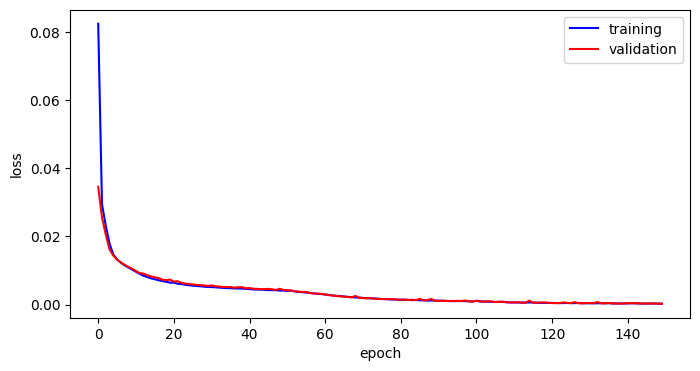

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 4.8437e-04
Epoch 1: val_loss did not improve from 0.00027
185/185 [==============================] - 7s 39ms/step - loss: 4.8437e-04 - val_loss: 3.3558e-04
Epoch 2/50
185/185 [==============================] - ETA: 0s - loss: 3.1365e-04
Epoch 2: val_loss did not improve from 0.00027
185/185 [==============================] - 7s 40ms/step - loss: 3.1365e-04 - val_loss: 6.5254e-04
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 4.9961e-04
Epoch 3: val_loss did not improve from 0.00027
185/185 [==============================] - 7s 38ms/step - loss: 4.9961e-04 - val_loss: 2.8679e-04
Epoch 4/50
185/185 [==============================] - ETA: 0s - loss: 3.2389e-04
Epoch 4: val_loss did not improve from 0.00027
185/185 [==============================] - 8s 42ms/step - loss: 3.2389e-04 - val_loss: 2.9198e-04
Epoch 5/50
185/185 [==============================] - ETA: 0s - loss: 2.8293e-04
Epoch 5: val_lo

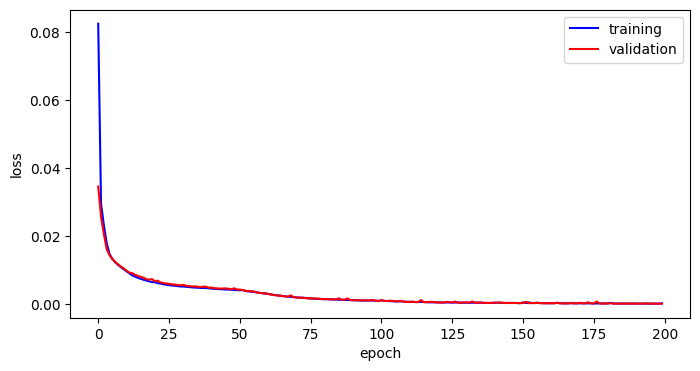

Epoch 1/50
369/370 [============================>.] - ETA: 0s - loss: 2.9652e-04
Epoch 1: val_loss did not improve from 0.00011
370/370 [==============================] - 15s 37ms/step - loss: 2.9642e-04 - val_loss: 2.1596e-04
Epoch 2/50
369/370 [============================>.] - ETA: 0s - loss: 1.8268e-04
Epoch 2: val_loss did not improve from 0.00011
370/370 [==============================] - 14s 37ms/step - loss: 1.8280e-04 - val_loss: 1.9689e-04
Epoch 3/50
369/370 [============================>.] - ETA: 0s - loss: 1.6604e-04
Epoch 3: val_loss did not improve from 0.00011
370/370 [==============================] - 14s 39ms/step - loss: 1.6611e-04 - val_loss: 1.5858e-04
Epoch 4/50
369/370 [============================>.] - ETA: 0s - loss: 1.6627e-04
Epoch 4: val_loss did not improve from 0.00011
370/370 [==============================] - 15s 40ms/step - loss: 1.6627e-04 - val_loss: 1.6302e-04
Epoch 5/50
370/370 [==============================] - ETA: 0s - loss: 1.6561e-04
Epoch 5: va

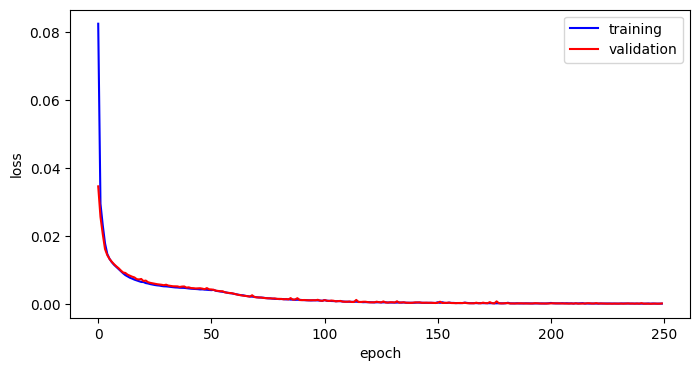

Execution time 1529.8396 seconds


In [6]:
# ##### Train the model
tic = time.perf_counter()
for n in ([7,6,5,4,3]):  
    # training in a cycle with increasing batch size  . IF i increase the size to 10 from 7 then the train process just stops after 5th cycle and this is because of the GPU memory issue.

    batch_size = 2**n  
    
    history = TCN_AE.fit(scaled_X_train, scaled_y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=(scaled_X_test, scaled_y_test),callbacks=[model_checkpoint_callback])
    
    loss_save = history.history['loss']
    val_loss_save = history.history['val_loss']
    if n in ([7,6,5,4,3]):
        
        loss_sum = np.concatenate((loss_sum, loss_save), axis = 0)
        val_loss_sum = np.concatenate((val_loss_sum, val_loss_save), axis = 0)
    else:
   
        loss_sum = loss_save
        val_loss_sum = val_loss_save  

    plot_losses(loss_sum,val_loss_sum)

toc = time.perf_counter()
print(f"Execution time {toc - tic:0.4f} seconds")



24/24 [==============================] - 2s 13ms/step
(740, 512, 1)


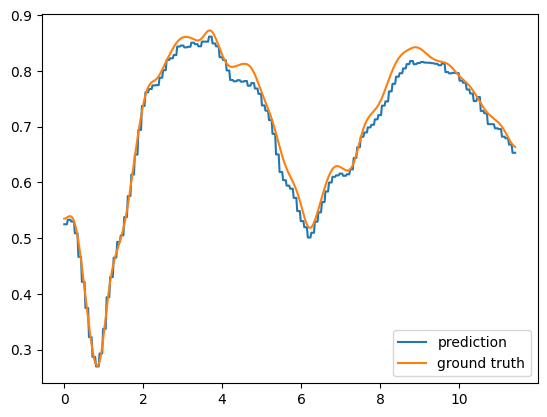

In [7]:
#Compute predicted values
prediction_test = TCN_AE.predict(scaled_X_test)
print(prediction_test.shape)


# # Create a StandardScaler object


plt.plot(t,prediction_test[50],label = 'prediction')
plt.plot(t,scaled_y_test[50], label = 'ground truth')
plt.legend()
plt.show()

In [8]:
r2_test = r2_score(scaled_y_test.reshape(-1), prediction_test.reshape(-1))
print(r2_test)

r2_test_set = [r2_score(scaled_y_test[i].reshape(-1), prediction_test[i].reshape(-1)) for i in range(len(scaled_y_test))]
print(len(r2_test_set))

0.9944414034444307
740


In [9]:

above = np.sum(np.array(r2_test_set) > 0.90)/740 * 100
print('$R^{2}$ above 90 :',above)

above1 = np.sum(np.array(r2_test_set) > 0.95)/740 * 100
print('$R^{2}$ above 95 :',above1)

$R^{2}$ above 90 : 100.0
$R^{2}$ above 95 : 97.2972972972973


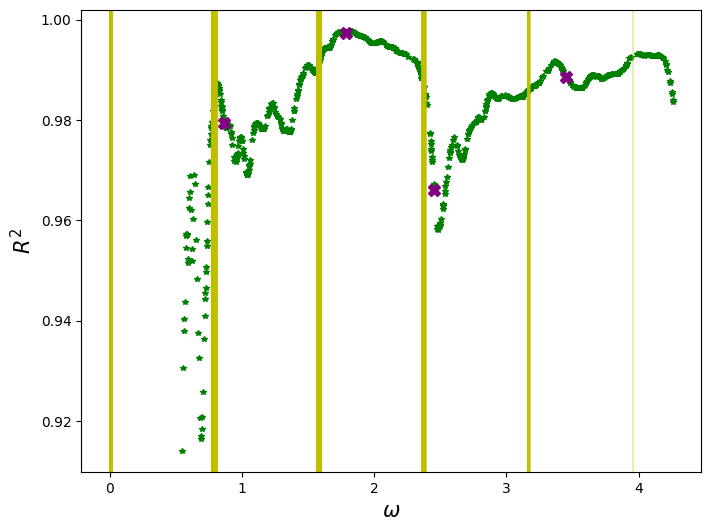

In [10]:
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed


plt.plot(omega_y_test, r2_test_set, '*', markersize=4, color='g')
# plt.plot(ω_test, r2_test_set, '.', color='red')
# Plot highlighted points in red

for i in [2, 100, 250, 600]:
    plt.plot(omega_y_test[i], r2_test_set[i], 'X',markersize=9, color='purple')


for _ in np.unique(np.round(np.abs(E[:, np.newaxis] - E), 4)):
    plt.axvline(_, c='y', alpha=0.3)
# plt.axhline(r2_test, color='blue', linestyle='--')  # Plot the horizontal line for r2_test
# plt.text(0.14, r2_test, f"Avg. $R^{2}$ = {r2_test:.4}", color='blue',fontsize=12,weight='bold', va='bottom', ha='left')  # Display the value of r2_test on the plot
plt.xlabel(r"$\omega$",fontsize=15)
plt.ylabel(r"$R^2$",fontsize=15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.title("$\omega$ vs. $R^2$ score")
#plt.title("Amplitude = 1", fontsize = 14)
# plt.savefig('R2_Omega_v4_1.png')
plt.savefig('outputs/A1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

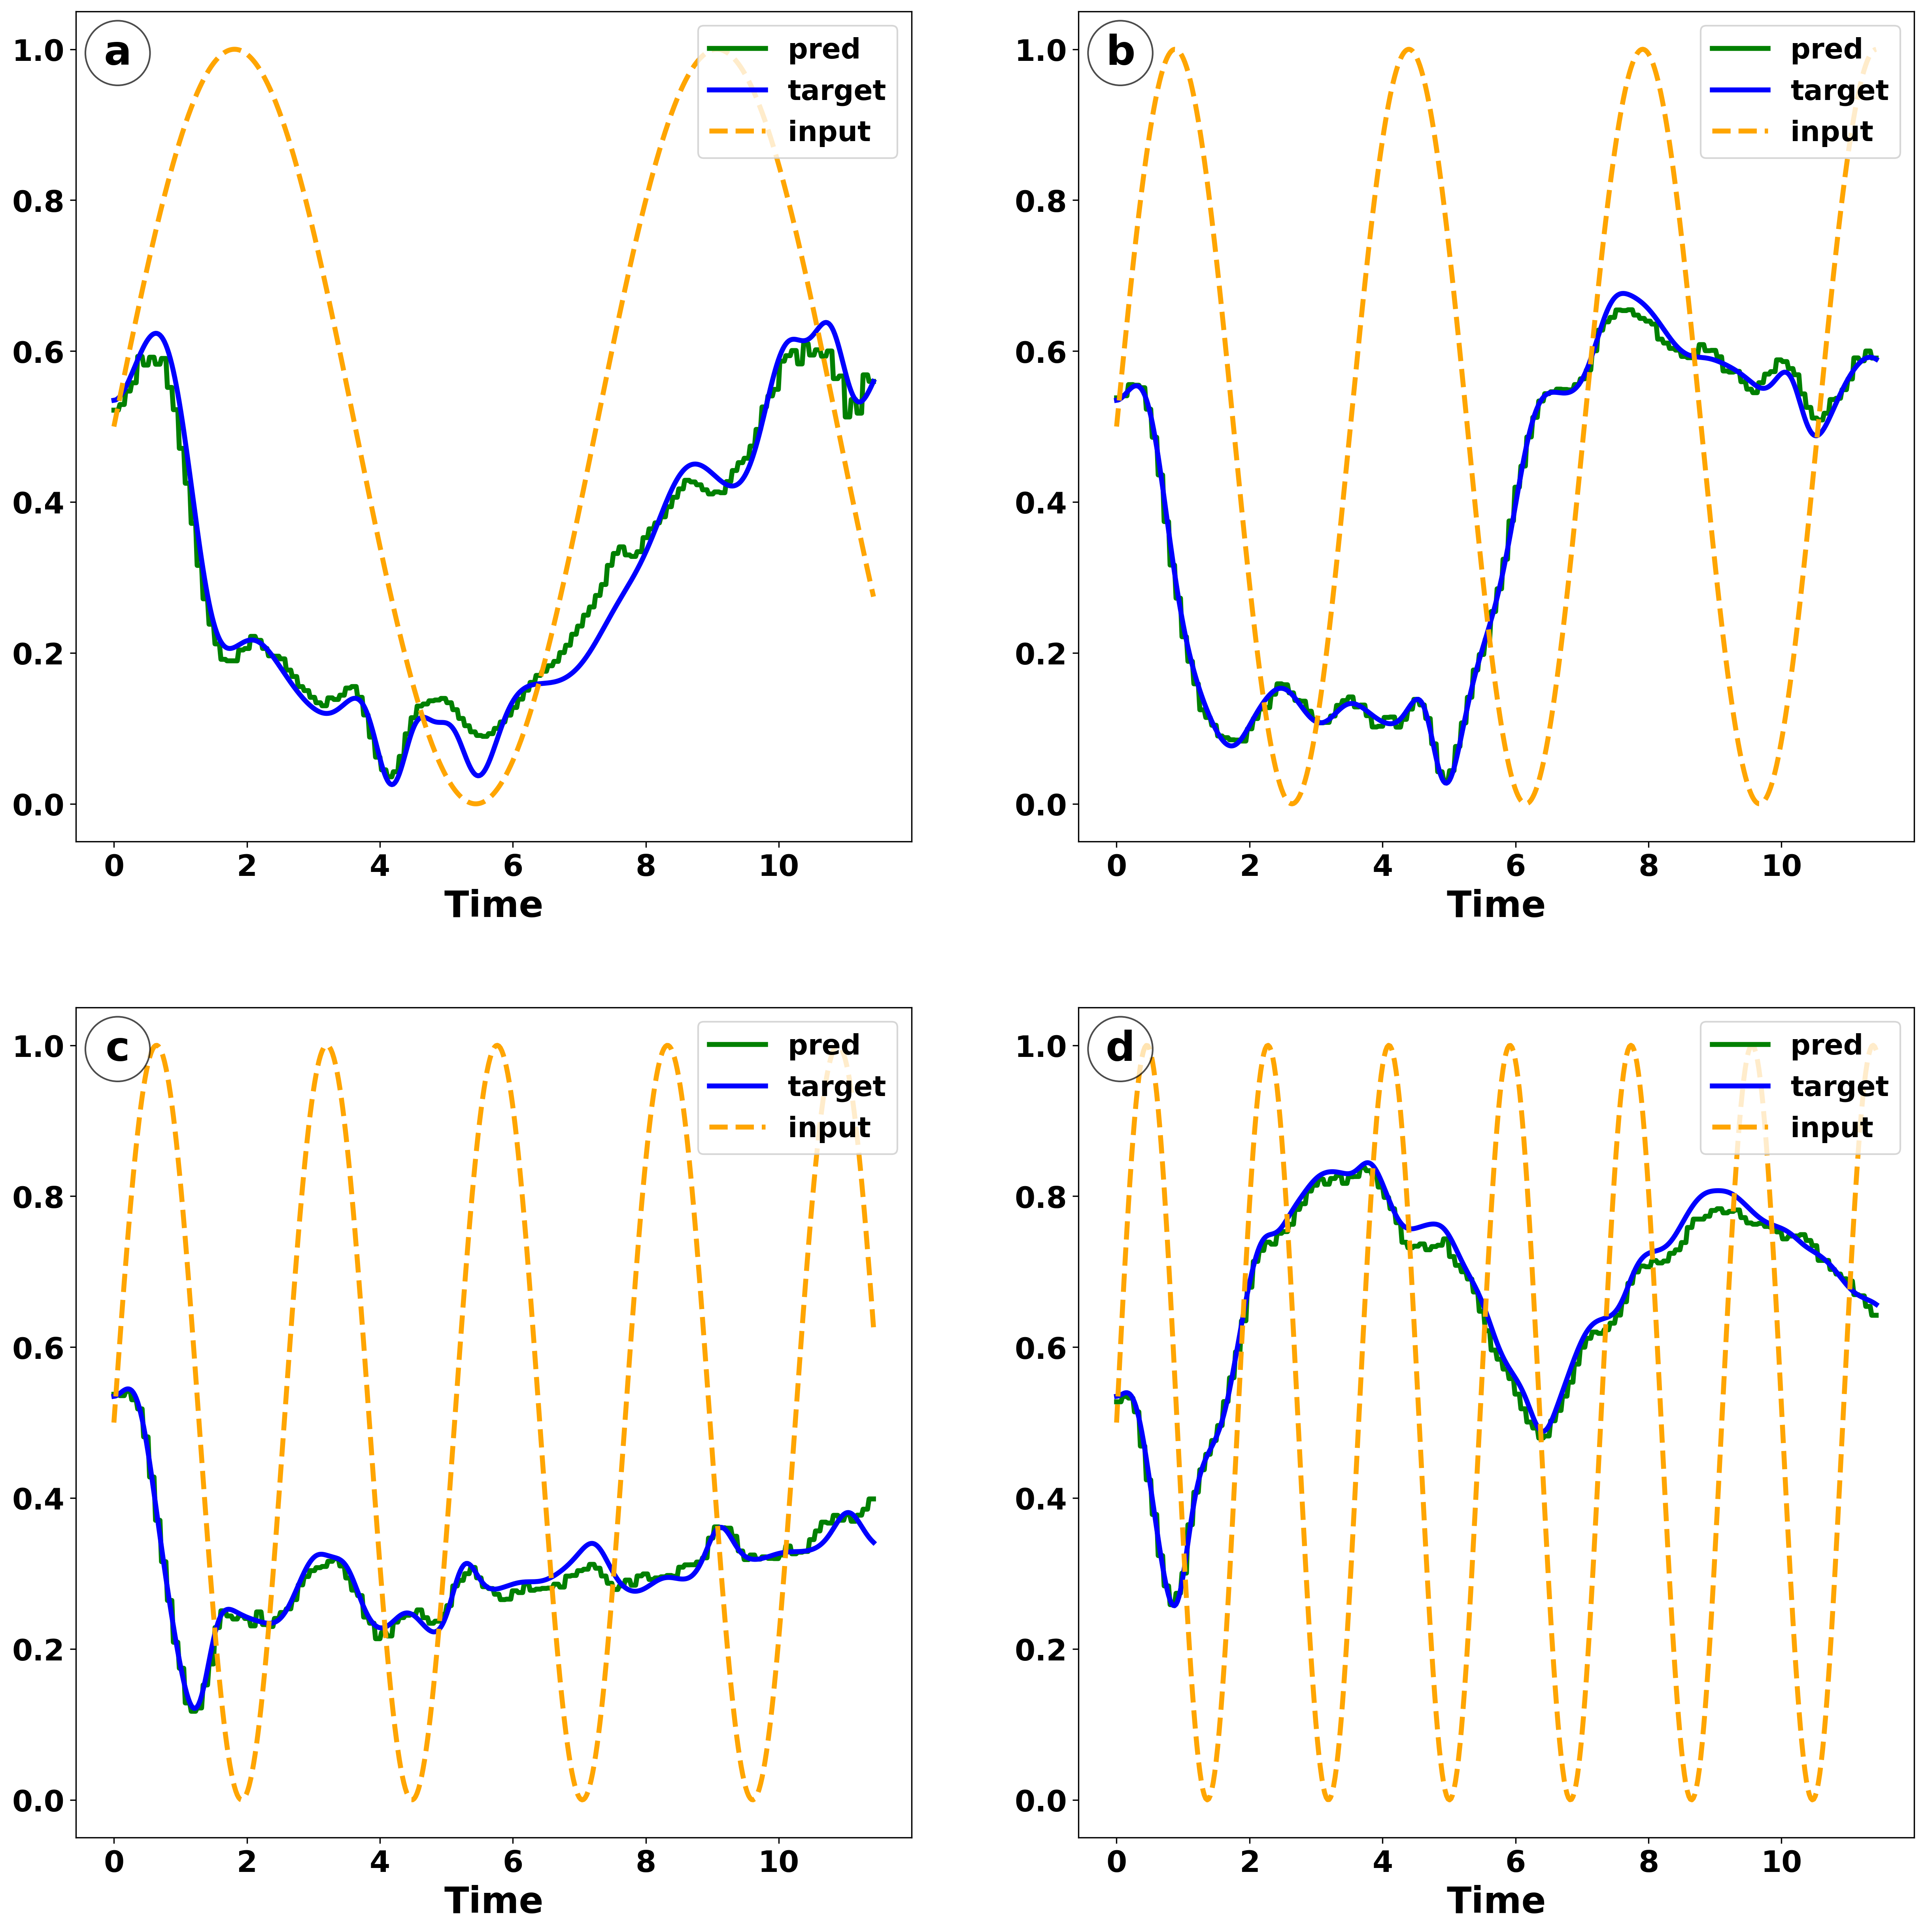

In [11]:

from matplotlib import rcParams

rcParams['font.weight'] = 'bold'
rcParams['font.size'] = 17
labels = ['a', 'b', 'c', 'd']

plt.figure(figsize=(20, 20), dpi=300)
arr =  np.array([2, 100, 250, 600])
j=0
for i in arr:
    plt.subplot(2, 2, j+1)
    plt.plot(t,prediction_test[i, :], label = "pred",color = 'green', linewidth=3)
    plt.plot(t, scaled_y_test[ i, :], label = "target", color = 'blue', linewidth=3  )
    plt.plot( t, scaled_X_test[i, :],'--', label = "input", color = 'orange', linewidth=3 )
    #plt.plot( t, F0 * np.sin(ω_train[i] * t),'--', label = "input",linewidth=4 )
    plt.legend(loc='upper right')
    #plt.title("ω = {}".format(omega_y_test[i]),fontsize=22)
    plt.xlabel("Time",fontsize=22)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
#     plt.ylabel("Expectation Value of Magnetization",  fontsize=27)
    plt.annotate(labels[j], xy=(0.05, 0.95), xycoords='axes fraction', fontsize=25,
                 ha='center', va='center',
                 bbox=dict(boxstyle='circle', fc='w', ec='k', lw=1, alpha=0.7))
    j=j+1

plt.savefig('outputs/chaotic1_5TEST.pdf', dpi=700, bbox_inches='tight')
plt.show()
